Preprocessing technique 1


```
%% Image input
% We take a RGB image as input and convert it to grayscale and store it in another variable, so we can get the mean luminance.

rgbImage=imread(im);
rgbImage=im2double(rgbImage);
grayImage = rgb2gray(rgbImage); 

%% White Balancing
% Extract the individual red, green, and blue color channels.
redChannel = rgbImage(:, :, 1);
greenChannel = rgbImage(:, :, 2);
blueChannel = rgbImage(:, :, 3);

meanR = mean2(redChannel);
meanG = mean2(greenChannel);
meanB = mean2(blueChannel);
meanGray = mean2(grayImage);

% Make all channels have the same mean
redChannel = (double(redChannel) * meanGray / meanR);
greenChannel = (double(greenChannel) * meanGray / meanG);
blueChannel = (double(blueChannel) * meanGray / meanB);

%redChannel and blueChannel Correction
redChannel=redChannel-0.3*(meanG-meanR).*greenChannel.*(1-redChannel);
blueChannel=blueChannel+0.3*(meanG-meanB).*greenChannel.*(1-blueChannel);


% Recombine separate color channels into a single, true color RGB image.
rgbImage_white_balance = cat(3, redChannel, greenChannel, blueChannel);


%% Gamma Correction and sharpening
I = imadjust(rgbImage_white_balance,[],[],0.5);
            
J=(rgbImage_white_balance+(rgbImage_white_balance-imgaussfilt(rgbImage_white_balance)));

%% Image Fusion using wavelet transform

XFUS = wfusimg(I,J,'sym4',3,'max','max');

B=histeq(XFUS);

```



## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [4]:
!nvidia-smi

Mon Mar 20 04:35:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **27.01.2023** with version **YOLOv8.0.20**.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [6]:
# Pip install method (recommended)

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 25.6/78.2 GB disk)


In [7]:
from ultralytics import YOLO

from IPython.display import display, Image

## CLI Basics 

If you want to train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started. Read more about CLI in [Ultralytics YOLO Docs](https://v8docs.ultralytics.com/cli/).

```
yolo task=detect    mode=train    model=yolov8n.yaml      args...
          classify       predict        yolov8n-cls.yaml  args...
          segment        val            yolov8n-seg.yaml  args...
                         export         yolov8n.pt        format=onnx  args...
```

## Inference with Pre-trained COCO Model

### 💻 CLI

`yolo mode=predict` runs YOLOv8 inference on a variety of sources, downloading models automatically from the latest YOLOv8 release, and saving results to `runs/predict`.

In [8]:
#Preprocess method 1
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="sbVEfNcsP5XDC8l7n0fv")
project = rf.workspace("fyp-camuo").project("biomass-estimation-v8-enh1")
dataset = project.version(1).download("yolov8")


/content/datasets
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to Biomass-estimation-v8-enh1-1 in yolov8:: 100%|██████████| 9162/9162 [00:02<00:00, 4083.57it/s]


In [2]:
# %cd {HOME}
# %ls
%cd {HOME}/gdrive/MyDrive/yolov8


[Errno 2] No such file or directory: '{HOME}/gdrive/MyDrive/yolov8'
/content


## Custom Training

In [9]:
%cd {HOME}/gdrive/MyDrive/yolov8

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=25 imgsz=800 plots=True save_txt=True

/content/gdrive/MyDrive/yolov8
Ultralytics YOLOv8.0.20 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/datasets/Biomass-estimation-v8-enh1-1/data.yaml, epochs=25, patience=50, batch=16, imgsz=800, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=True, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, o

In [10]:
!ls {HOME}/gdrive/MyDrive/yolov8/runs/detect/train7/

args.yaml					    train_batch2.jpg
confusion_matrix.png				    train_batch3015.jpg
events.out.tfevents.1679287036.2016cc36c530.2276.0  train_batch3016.jpg
F1_curve.png					    train_batch3017.jpg
labels						    val_batch0_labels.jpg
P_curve.png					    val_batch0_pred.jpg
PR_curve.png					    val_batch1_labels.jpg
R_curve.png					    val_batch1_pred.jpg
results.csv					    val_batch2_labels.jpg
results.png					    val_batch2_pred.jpg
train_batch0.jpg				    weights
train_batch1.jpg


/content/gdrive/MyDrive/yolov8


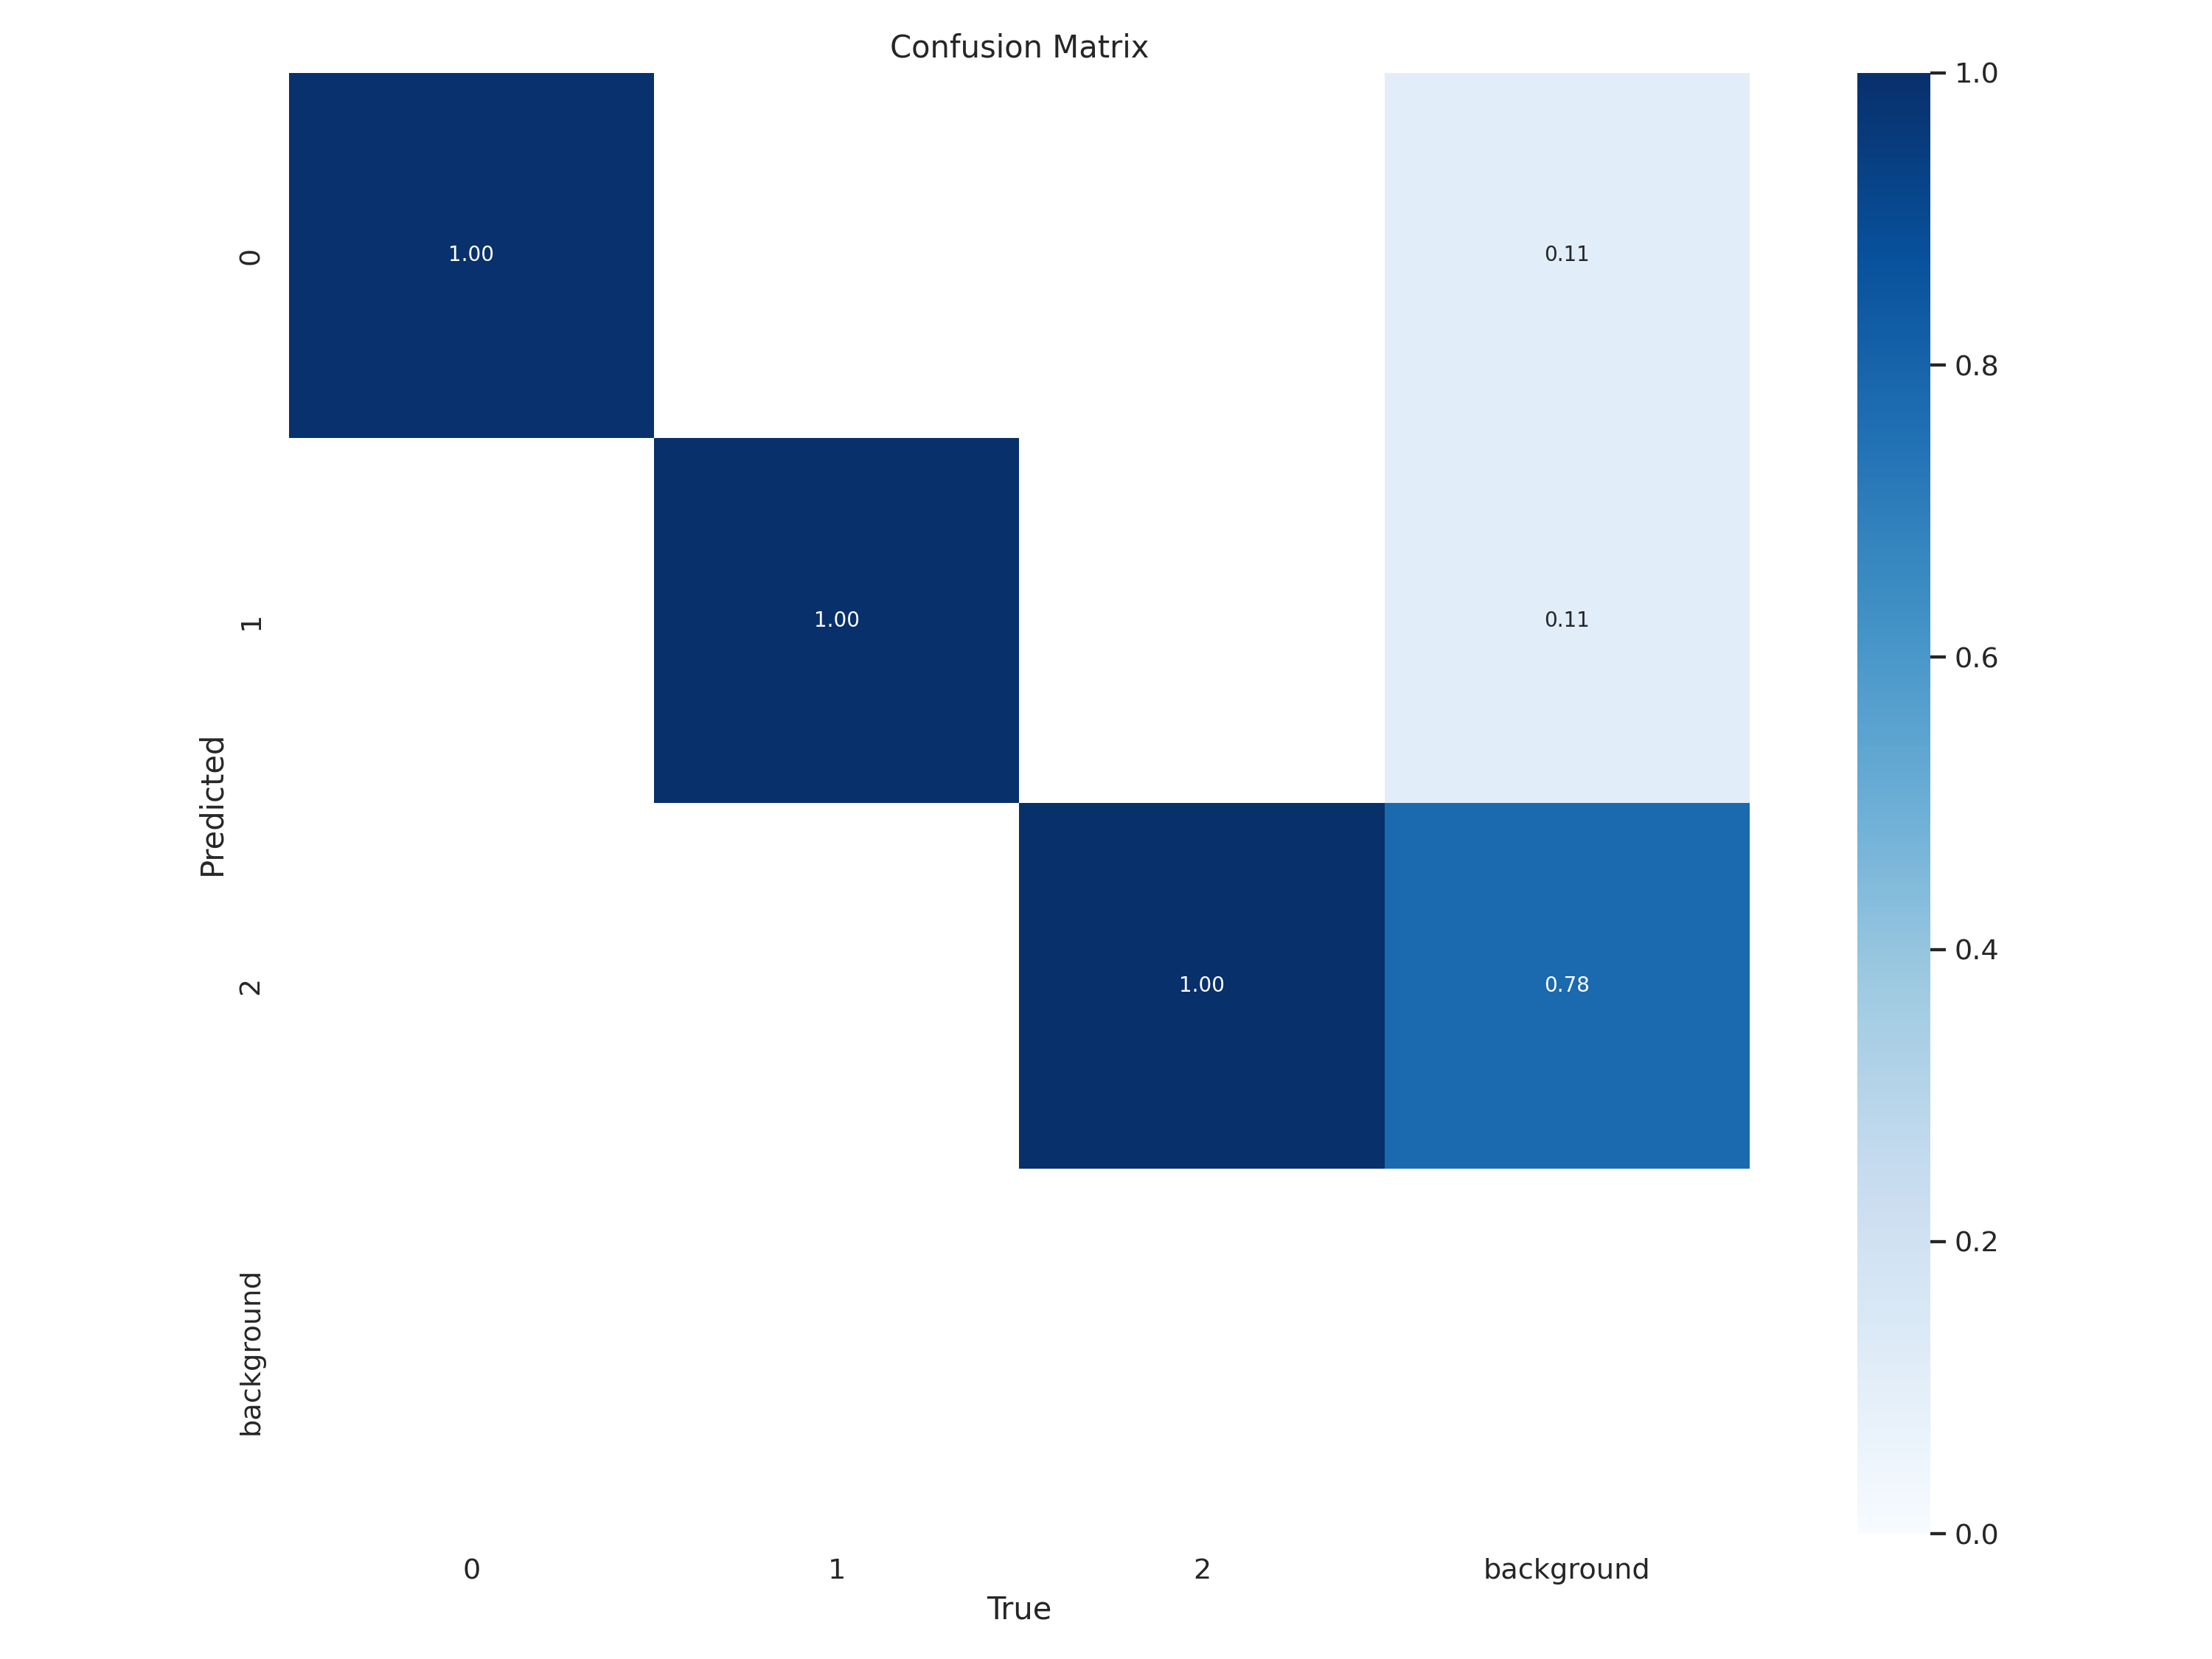

In [11]:
%cd {HOME}/gdrive/MyDrive/yolov8
Image(filename=f'{HOME}/gdrive/MyDrive/yolov8/runs/detect/train7/confusion_matrix.png', width=600)

/content/gdrive/MyDrive/yolov8


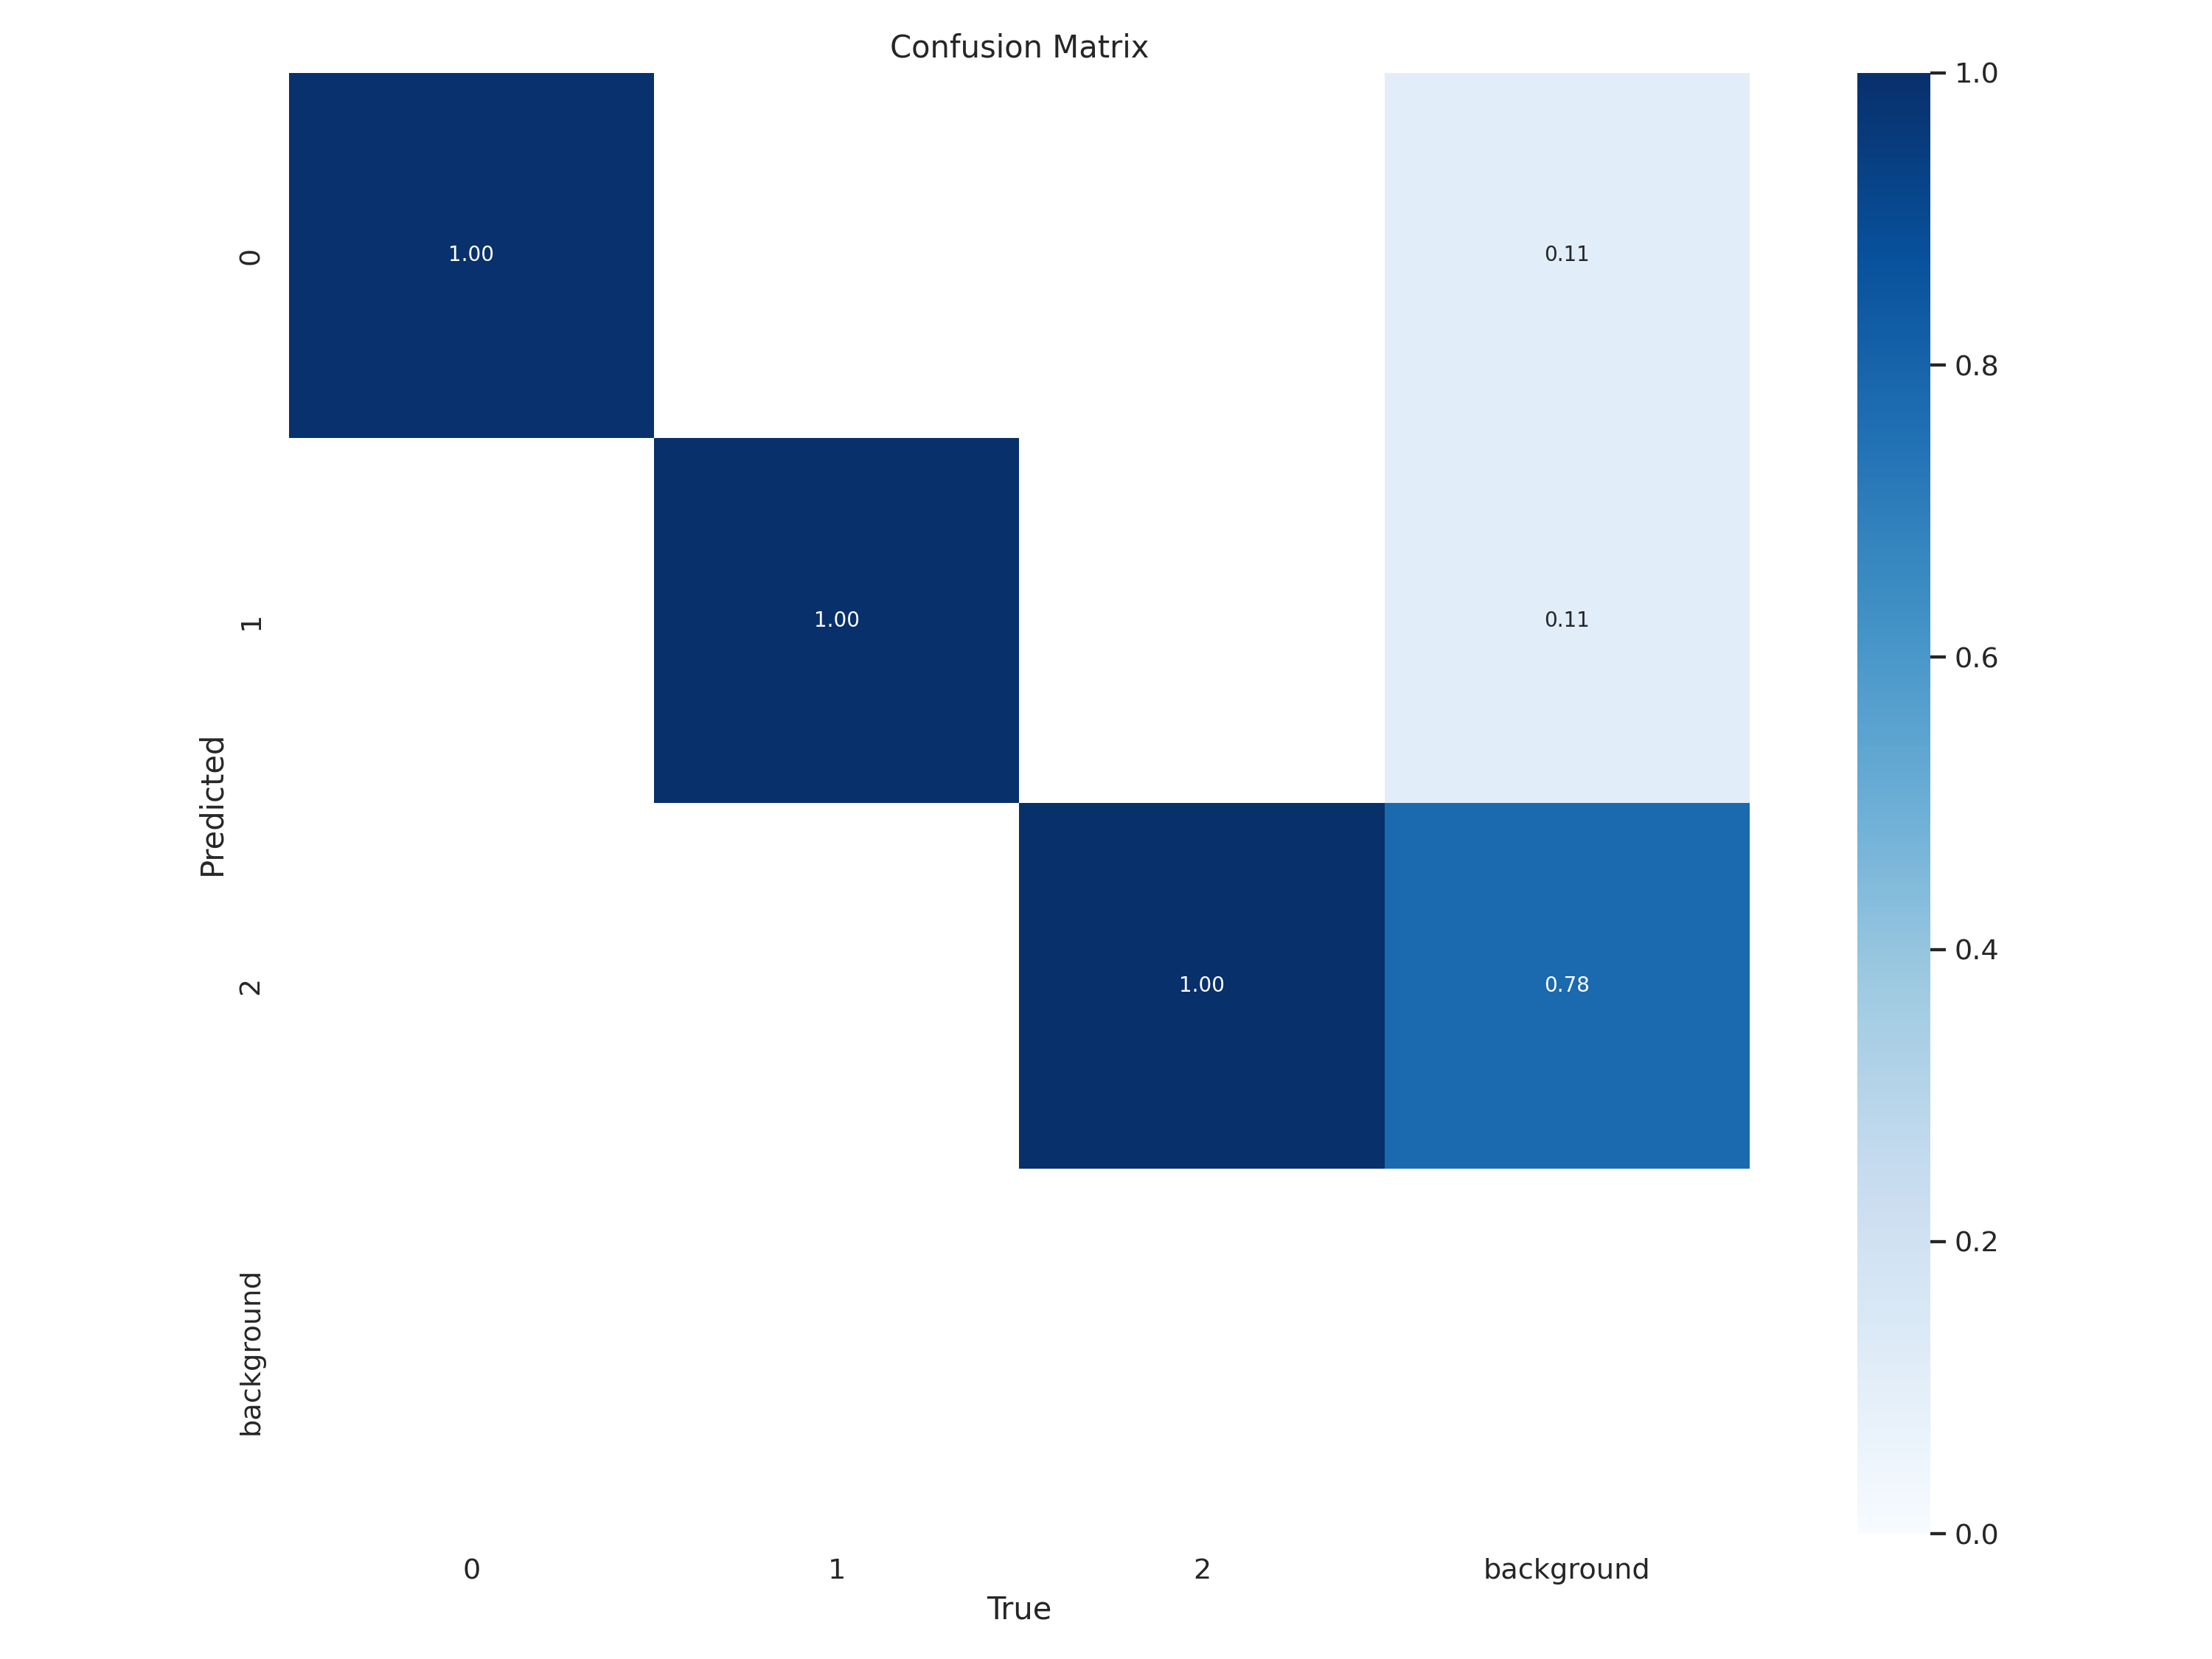

In [12]:
# With preprocessing 1
%cd {HOME}/gdrive/MyDrive/yolov8
Image(filename=f'{HOME}/gdrive/MyDrive/yolov8/runs/detect/train7/confusion_matrix.png', width=600)

/content/gdrive/MyDrive/yolov8


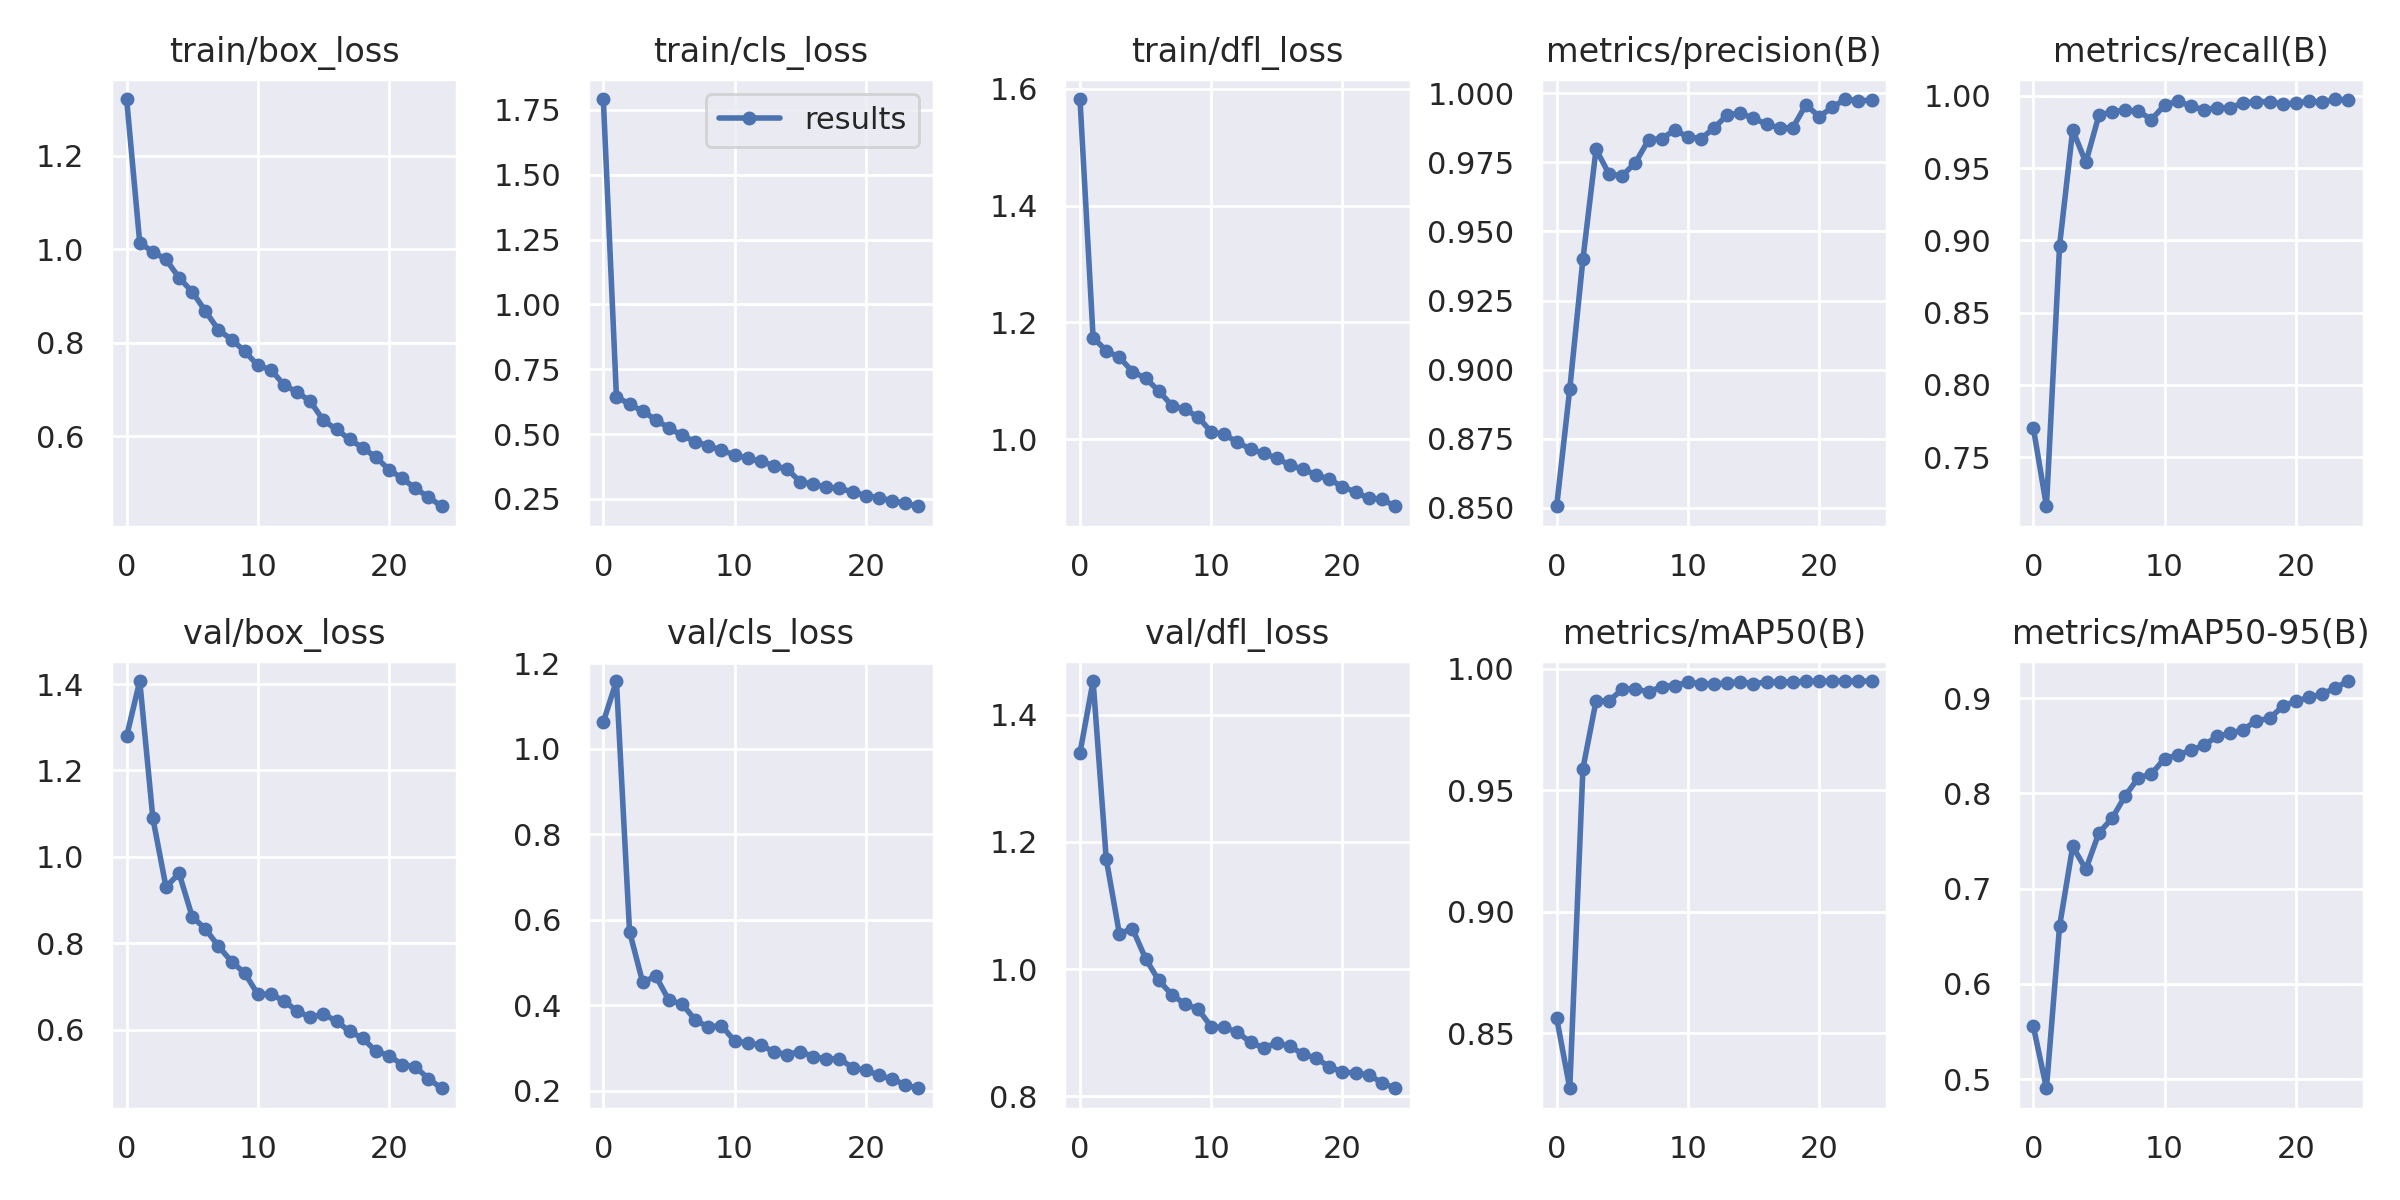

In [13]:
%cd {HOME}/gdrive/MyDrive/yolov8
Image(filename=f'{HOME}/gdrive/MyDrive/yolov8/runs/detect/train7/results.png', width=600)

/content/gdrive/MyDrive/yolov8


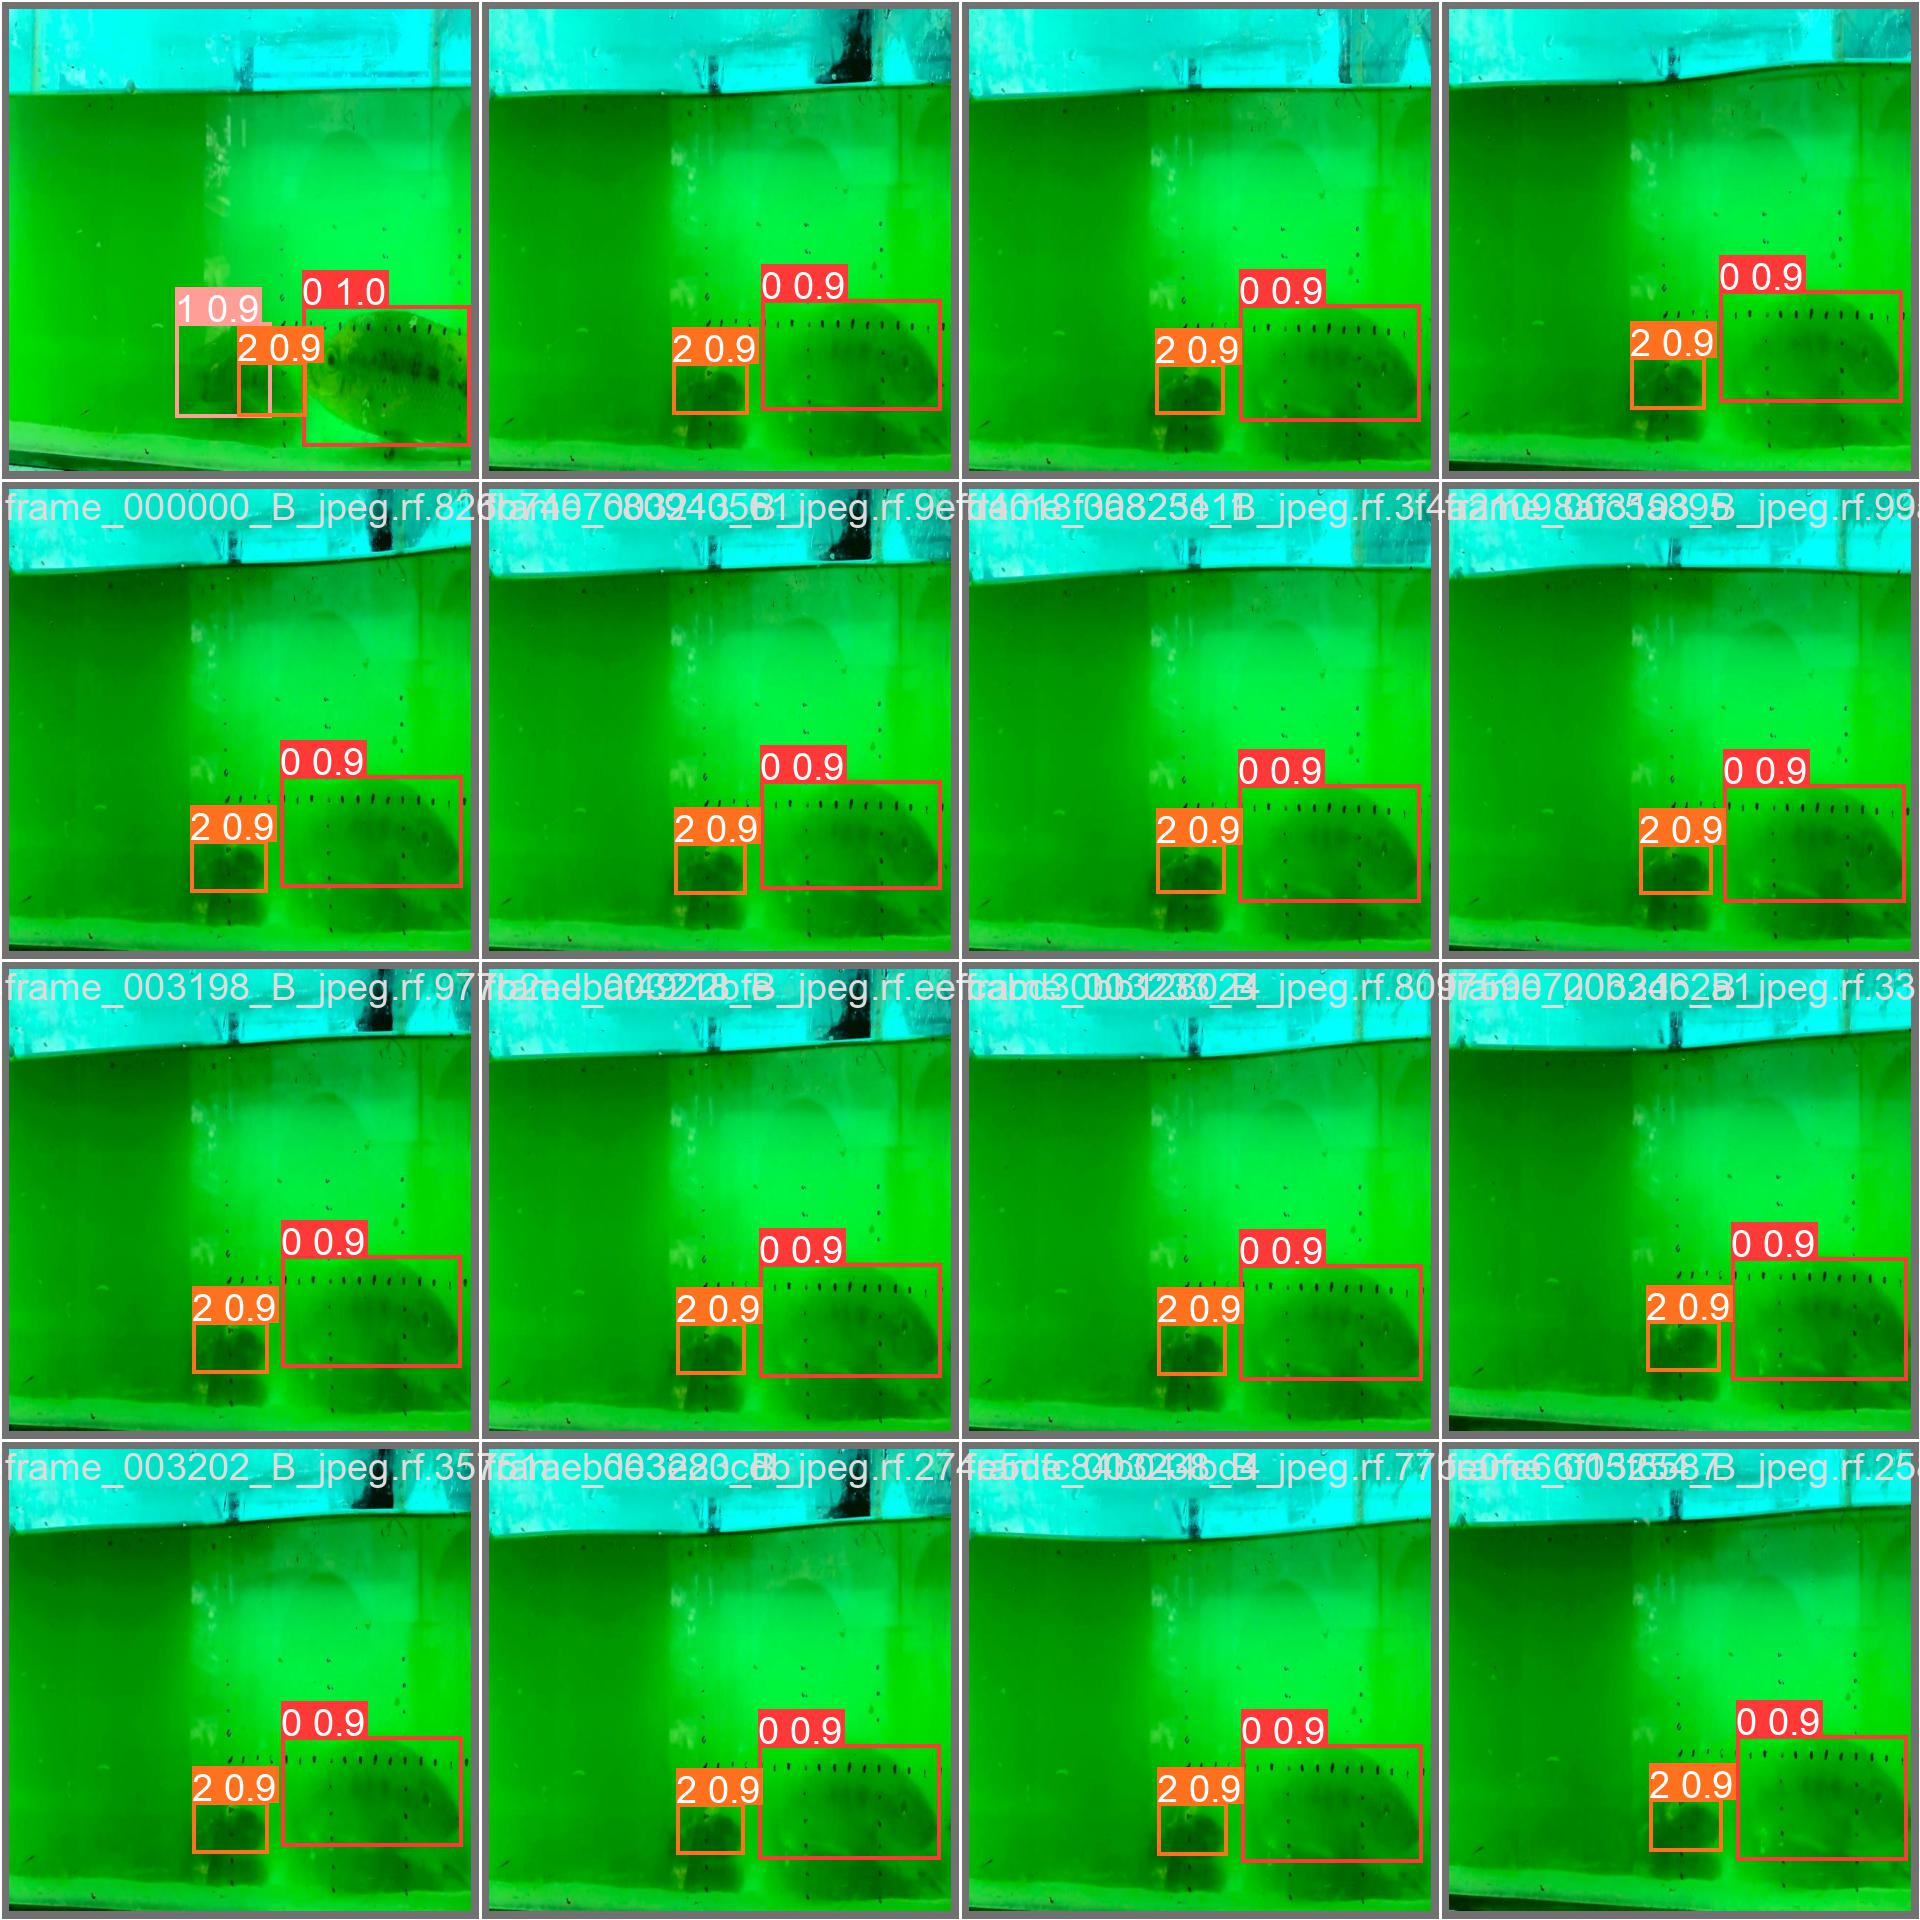

In [14]:
# With preprocessing 1
%cd {HOME}/gdrive/MyDrive/yolov8
Image(filename=f'{HOME}/gdrive/MyDrive/yolov8/runs/detect/train7/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [15]:
# With preprocess 1
%cd {HOME}/gdrive/MyDrive/yolov8/runs/detect/train7/weights/

!yolo task=detect mode=val model={HOME}/gdrive/MyDrive/yolov8/runs/detect/train7/weights/best.pt data={dataset.location}/data.yaml

/content/gdrive/MyDrive/yolov8/runs/detect/train7/weights
Ultralytics YOLOv8.0.20 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/Biomass-estimation-v8-enh1-1/valid/labels.cache... 915 images, 0 backgrounds, 0 corrupt: 100% 915/915 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 58/58 [00:22<00:00,  2.55it/s]
                   all        915       2151      0.998      0.997      0.995      0.918
                     0        915        896      0.999      0.994      0.995      0.958
                     1        915        589      0.998          1      0.995      0.926
                     2        915        666      0.996      0.997      0.995       0.87
Speed: 0.8ms pre-process, 13.6ms inference, 0.0ms loss, 1.8ms post-process per image


## Inference with Custom Model

In [16]:
%cd {HOME}/gdrive/MyDrive/yolov8
!yolo task=detect mode=predict model={HOME}/gdrive/MyDrive/yolov8/runs/detect/train7/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True save_txt=True

/content/gdrive/MyDrive/yolov8
Ultralytics YOLOv8.0.20 🚀 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
image 1/458 /content/datasets/Biomass-estimation-v8-enh1-1/test/images/frame_000004_B_jpeg.rf.92ccac1651fe93ae26acb538098e8138.jpg: 800x800 1 0, 1 1, 1 2, 26.1ms
image 2/458 /content/datasets/Biomass-estimation-v8-enh1-1/test/images/frame_000007_B_jpeg.rf.1bd4b89f09a2f9e64d52ccde809cb255.jpg: 800x800 1 0, 1 1, 1 2, 26.1ms
image 3/458 /content/datasets/Biomass-estimation-v8-enh1-1/test/images/frame_000044_B_jpeg.rf.e82fc9a88ec998904ba9733edbd2d2c5.jpg: 800x800 1 0, 1 1, 1 2, 26.1ms
image 4/458 /content/datasets/Biomass-estimation-v8-enh1-1/test/images/frame_000046_B_jpeg.rf.76ca296bffb3965045c7237a356a711f.jpg: 800x800 1 0, 1 1, 1 2, 26.1ms
image 5/458 /content/datasets/Biomass-estimation-v8-enh1-1/test/images/frame_000053_B_jpeg.rf.10294dca17008a22e7a796e019fc3c17.jpg: 800x800 1 0, 1 1, 1 2

**NOTE:** Let's take a look at few results.

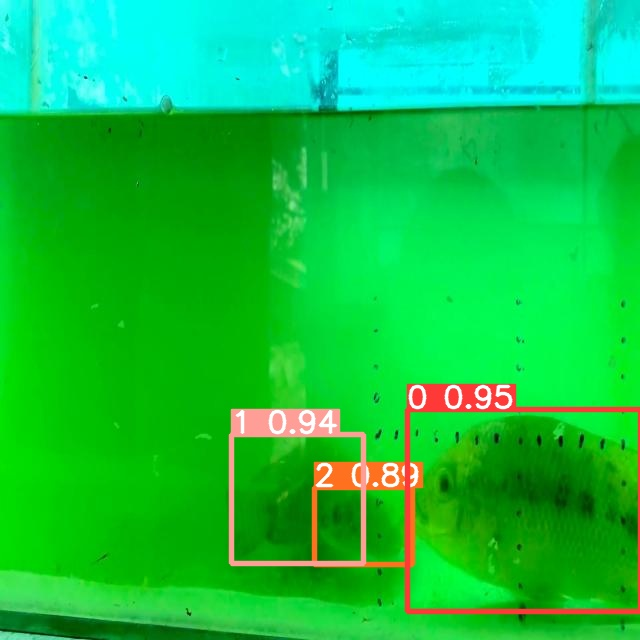

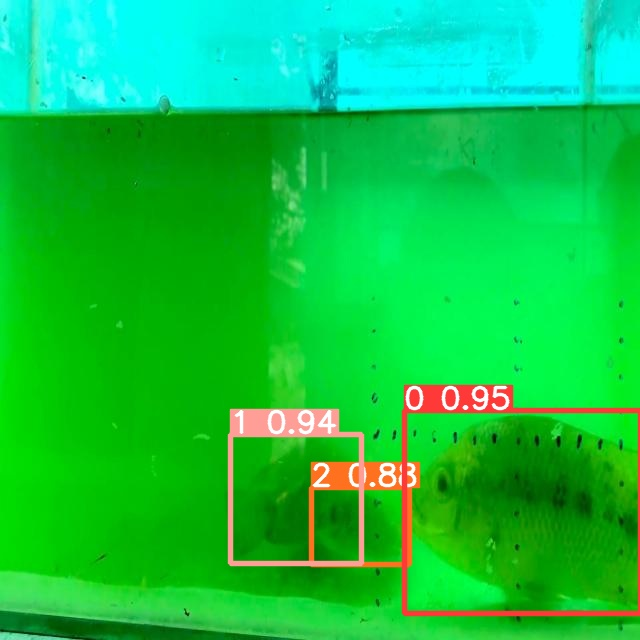

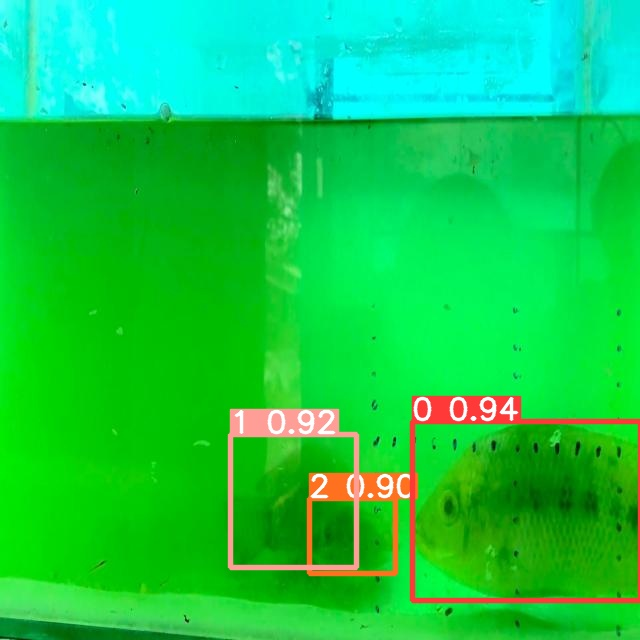

In [17]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/gdrive/MyDrive/yolov8/runs/detect/predict7/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")